# ConvNet2 Convolutional Neural Network Classification
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Add, Activation, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [1]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()


/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

## Introduction

This notebook contains the code for image classification using a two-layered CNN, ConvNet2.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## ConvNet2 Convolutional Neural Network (CNN) Classifier

A two-layered CNN classifier, ConvNet2, is implemented below.

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(img_res, X_band_train, X_band_val, X_band_test, X_rgb_train, X_rgb_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    weights_str = None
        
    img_h = img_res
    img_w = img_res
    batch_Size = 10 #8 #4 #16 #8 #10 #64
    
    print(single_model_name_str)
    
    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    input1 = Input(shape=(img_h, img_w, 3))
    net_1 = Conv2D(32, (3, 3,), activation='relu', padding='same')(input1)
    net_1 = BatchNormalization()(net_1)
    print(input1.shape)
    #print(net_1.shape)
    net_1 = MaxPool2D(pool_size=(2,2))(net_1)
    net_1 = Conv2D(64,  (3, 3,), activation='relu', padding='same')(net_1)
    net_1 = BatchNormalization()(net_1)
    net_1 = MaxPool2D(pool_size=(2,2))(net_1)
    net_1 = GlobalAveragePooling2D()(net_1)
    net_1 = Dropout(dropout)(net_1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(net_1)
        
    input2 = Input(shape=(img_h, img_w, 3))
    net_2 = Conv2D(32,  (3, 3,), activation='relu', padding='same')(input2)    
    net_2 = BatchNormalization()(net_2)
    net_2 = MaxPool2D(pool_size=(2,2))(net_2)
    net_2 = Conv2D(64,  (3, 3,), activation='relu', padding='same')(net_2)
    net_2 = BatchNormalization()(net_2)
    net_2 = MaxPool2D(pool_size=(2,2))(net_2)
    net_2 = GlobalAveragePooling2D()(net_2)
    net_2 = Dropout(dropout)(net_2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(net_2) 

    preds = Average()([preds1, preds2])

    #for layer in net_2.layers:
     #   layer.name = layer.name + str('_2')
    
    cnn_model = Model(inputs = [input1, input2], outputs = preds, name='ensemble')

    print(' 1 input shape:', input1.shape)
    print(' 1 output shape:', preds1.shape)
    
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    chkpt_path = './model/' + single_model_name_str + '_Simple_Neural_Network_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
        
    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_Simple_NN_Architecture.png')
    
    #Visualisation code adapted from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Simple_NN_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Simple_NN_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
     
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    return X_reshaped, X.shape[0]

def shapeExpander(X, num_blobs, num_bands):
    X_reshaped = X.reshape(num_blobs, img_res, img_res, num_bands)
    return X_reshaped

def scaleData(X_train, X_val, X_test):
    print('Train, Val and Test Data shapes: ', X_train.shape, X_val.shape, X_test.shape)
    X_train, train_no = reshaper(X_train)
    X_val, val_no = reshaper(X_val)
    X_test, test_no = reshaper(X_test)
    print('Reshaped Train, Val and Test Data shapes: ', X_train.shape, X_val.shape, X_test.shape)

    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = shapeExpander(X_train_scaled, train_no, 3)
    X_val_scaled = shapeExpander(X_val_scaled, val_no, 3)
    X_test_scaled = shapeExpander(X_test_scaled, test_no, 3)
    print('Train, Scaled Val and Scaled Test Data shapes: ', X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
    del scaler, X_train, X_val, X_test
    return X_train_scaled, X_val_scaled, X_test_scaled


#Function to train model 
def trainModel(img_res, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, 
               y_train_val, y_test):
        
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sss.get_n_splits(X_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['Simple NN Dropout: ' + str(dropout[0]), 'Simple NN Dropout: ' + str(dropout[1]), 
                         'Simple NN Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    """
    ensemble_names = ['Ensemble of 1 & 2',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    """
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ',counter)
        print(datetime.now())
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        X_band_train = X_band_train_val[train_index].copy()
        X_band_val = X_band_train_val[val_index].copy()
        X_band_test_copy = X_band_test.copy()
        X_rgb_train = X_rgb_train_val[train_index].copy()
        X_rgb_val = X_rgb_train_val[val_index].copy()
        X_rgb_test_copy = X_rgb_test.copy()
        print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
        print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
                
        X_band_train, X_band_val, X_band_test_copy = scaleData(X_band_train, X_band_val, X_band_test_copy)
        X_rgb_train, X_rgb_val, X_rgb_test_copy = scaleData(X_rgb_train, X_rgb_val, X_rgb_test_copy)
        
        # Model 1
        preds_1, test_preds_1, results_arr = singleModel(img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
           
        preds_2, test_preds_2, results_arr = singleModel(img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
              
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        #New del
        del X_band_train, X_band_val, X_band_test_copy, X_rgb_train, X_rgb_val, X_rgb_test_copy
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test
    return results_data

2020-10-26 03:20:55.745927
X, y shapes:  (1440, 224, 224, 6) (1440,)
X_band_train_val processed: max, min 255.0 0.0
X_rgb_train_val processed: max, min 255.0 0.0
X_band_test processed: max, min 255.0 0.0
X_rgb_test processed: max, min 255.0 0.0
Model 1: Simple NN Dropout: 0.2
Model 2: Simple NN Dropout: 0.3
Model 3: Simple NN Dropout: 0.4
Overlap set()
Counter:  0
2020-10-26 03:20:57.518500
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) 

92/92 [==============================] - 7s 76ms/step - loss: 0.3955 - acc: 0.8110 - val_loss: 0.3547 - val_acc: 0.8571

Epoch 00021: val_loss improved from 0.35630 to 0.35470, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 22/50
92/92 [==============================] - 7s 77ms/step - loss: 0.3999 - acc: 0.8185 - val_loss: 0.3525 - val_acc: 0.8571

Epoch 00022: val_loss improved from 0.35470 to 0.35249, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 23/50
92/92 [==============================] - 7s 77ms/step - loss: 0.3995 - acc: 0.8152 - val_loss: 0.3519 - val_acc: 0.8571

Epoch 00023: val_loss improved from 0.35249 to 0.35186, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 24/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4003 - acc: 0.8077 - val_loss: 0.3532 - val_acc: 0.8528

Epoch 00024: val_loss did not improve from 0.35186
Epoch 25/

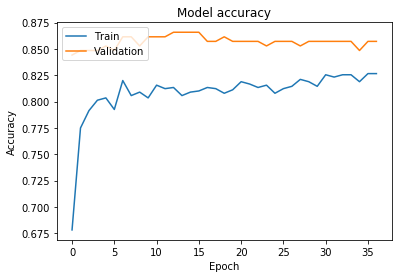

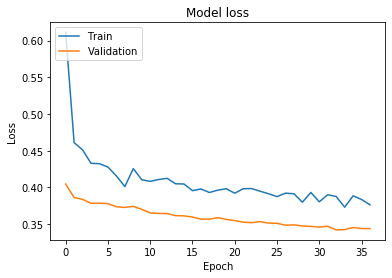

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[115  29]
 [ 19 125]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 19 false negatives and 125 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.6491 - acc: 0.6163 - val_loss: 0.4145 - val_acc: 0.8225

Epoch 00001: val_loss improved from inf to 0.41453, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4641 - acc: 0.7751 - val_loss: 0.3736 - val_acc: 0.8528

Epoch 00002: val_loss improved from 0.41453 to 0.37357, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4406 - acc: 0.7869 - val_loss: 0.3631

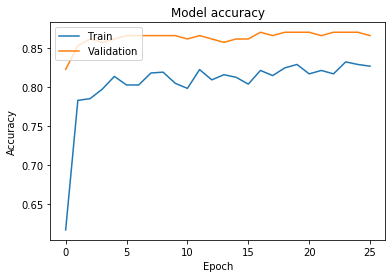

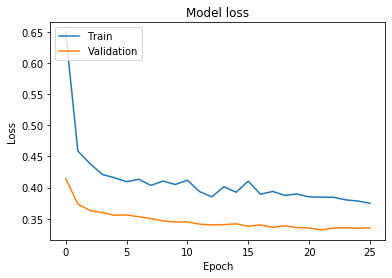

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[108  36]
 [ 17 127]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 17 false negatives and 127 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.5803 - acc: 0.6902 - val_loss: 0.4010 - val_acc: 0.8571

Epoch 00001: val_loss improved from inf to 0.40097, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4713 - acc: 0.7706 - val_loss: 0.3801 - val_acc: 0.8442

Epoch 00002: val_loss improved from 0.40097 to 0.38009, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4568 - acc: 0.7696 - val_loss: 0.3784

92/92 [==============================] - 7s 76ms/step - loss: 0.4081 - acc: 0.8066 - val_loss: 0.3498 - val_acc: 0.8571

Epoch 00033: val_loss did not improve from 0.34882
Epoch 34/50
92/92 [==============================] - 7s 77ms/step - loss: 0.3894 - acc: 0.8195 - val_loss: 0.3500 - val_acc: 0.8571

Epoch 00034: val_loss did not improve from 0.34882
Epoch 00034: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Dropout: 0.4 : Counter: 0, Accuracies: Validation: 86.58 %, Test: 81.60 %


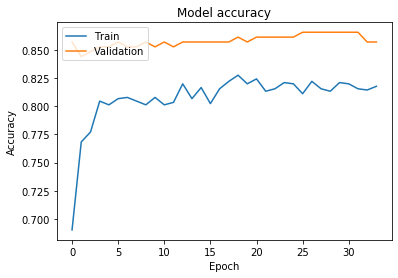

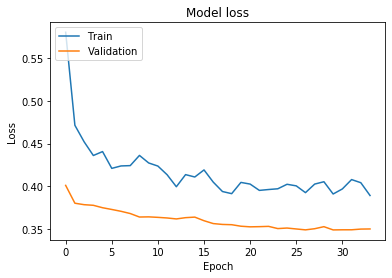

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[109  35]
 [ 18 126]]
From the confusion matrix above there are 109 true negatives and 35 false positives.
There are 18 false negatives and 126 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   

   Simple NN Dropout: 0.2 Recall  Simple NN Dropout: 0.2 True Neg.  \
0                           0.83                             115.0   

   Simple NN Dropout: 0.2 False Pos.  Simple NN Dropout: 0.2 False Neg.  \
0                               29.0                               19.0   

   Simple NN Dropout: 0.2 True Pos.  ...  Simple NN Dropout: 0.3 True Pos.  \
0                             125.0  ...                     

92/92 [==============================] - 7s 76ms/step - loss: 0.4161 - acc: 0.8130 - val_loss: 0.3454 - val_acc: 0.8268

Epoch 00022: val_loss improved from 0.34572 to 0.34543, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 23/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4077 - acc: 0.8261 - val_loss: 0.3450 - val_acc: 0.8182

Epoch 00023: val_loss improved from 0.34543 to 0.34495, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 24/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4160 - acc: 0.8239 - val_loss: 0.3440 - val_acc: 0.8182

Epoch 00024: val_loss improved from 0.34495 to 0.34403, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 25/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4015 - acc: 0.8206 - val_loss: 0.3439 - val_acc: 0.8225

Epoch 00025: val_loss improved from 0.34403 to 0.34391, savi

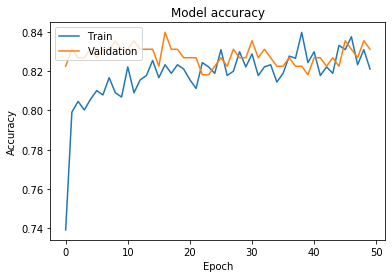

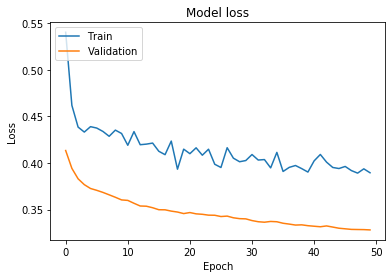

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[111  33]
 [ 14 130]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 14 false negatives and 130 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 85ms/step - loss: 0.5413 - acc: 0.7261 - val_loss: 0.3983 - val_acc: 0.8485

Epoch 00001: val_loss improved from inf to 0.39831, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4640 - acc: 0.7892 - val_loss: 0.3751 - val_acc: 0.8528

Epoch 00002: val_loss improved from 0.39831 to 0.37506, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 78ms/step - loss: 0.4559 - acc: 0.8000 - val_loss: 0.3695

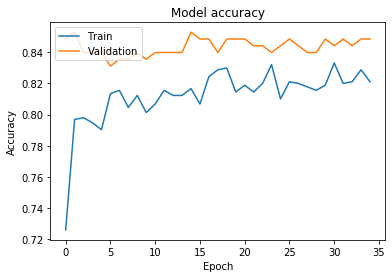

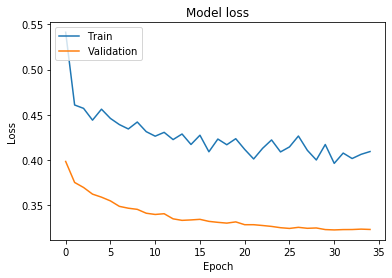

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[116  28]
 [ 19 125]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 19 false negatives and 125 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 80ms/step - loss: 0.5759 - acc: 0.6946 - val_loss: 0.4091 - val_acc: 0.8355

Epoch 00001: val_loss improved from inf to 0.40910, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4896 - acc: 0.7751 - val_loss: 0.3872 - val_acc: 0.8442

Epoch 00002: val_loss improved from 0.40910 to 0.38724, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4596 - acc: 0.7945 - val_loss: 0.3772

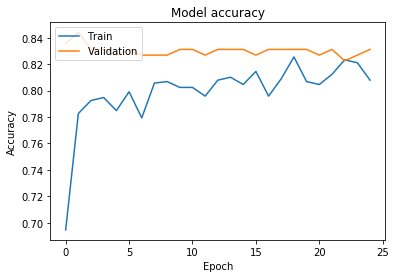

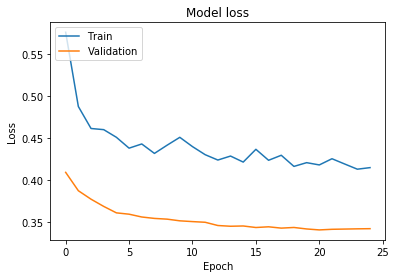

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[117  27]
 [ 19 125]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 19 false negatives and 125 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   
1                             0.84                              0.84   

   Simple NN Dropout: 0.2 Recall  Simple NN Dropout: 0.2 True Neg.  \
0                           0.83                             115.0   
1                           0.84                             111.0   

   Simple NN Dropout: 0.2 False Pos.  Simple NN Dropout: 0.2 False Neg

92/92 [==============================] - 7s 78ms/step - loss: 0.4095 - acc: 0.8033 - val_loss: 0.3814 - val_acc: 0.8355

Epoch 00021: val_loss improved from 0.38197 to 0.38143, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 22/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3944 - acc: 0.8152 - val_loss: 0.3824 - val_acc: 0.8355

Epoch 00022: val_loss did not improve from 0.38143
Epoch 23/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4041 - acc: 0.8153 - val_loss: 0.3820 - val_acc: 0.8355

Epoch 00023: val_loss did not improve from 0.38143
Epoch 24/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3977 - acc: 0.8228 - val_loss: 0.3822 - val_acc: 0.8355

Epoch 00024: val_loss did not improve from 0.38143
Epoch 25/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4139 - acc: 0.8043 - val_loss: 0.3821 - val_acc: 0.8355

Epoch 00025: val_loss did not improve from 0.38143
Epo

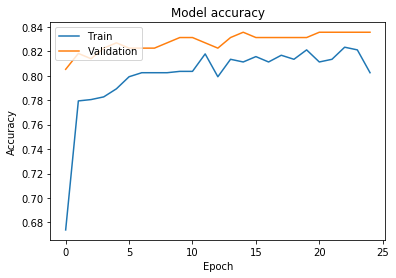

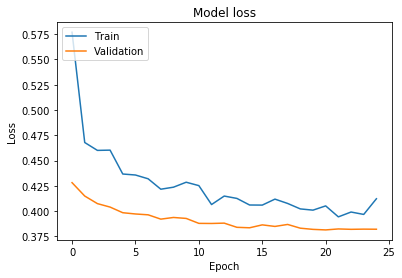

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[106  38]
 [ 14 130]]
From the confusion matrix above there are 106 true negatives and 38 false positives.
There are 14 false negatives and 130 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.6075 - acc: 0.6783 - val_loss: 0.4548 - val_acc: 0.7749

Epoch 00001: val_loss improved from inf to 0.45475, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4716 - acc: 0.7827 - val_loss: 0.4280 - val_acc: 0.7965

Epoch 00002: val_loss improved from 0.45475 to 0.42797, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 81ms/step - loss: 0.4610 - acc: 0.7967 - val_loss: 0.4126

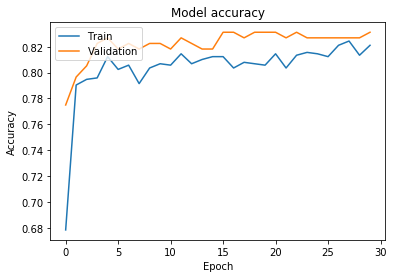

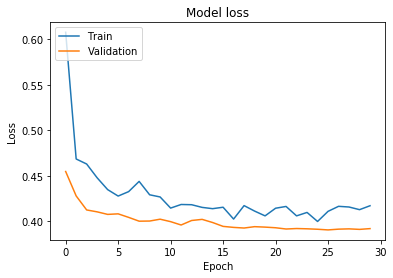

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[108  36]
 [ 16 128]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 16 false negatives and 128 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.6029 - acc: 0.6696 - val_loss: 0.4337 - val_acc: 0.8095

Epoch 00001: val_loss improved from inf to 0.43366, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4832 - acc: 0.7588 - val_loss: 0.4157 - val_acc: 0.8095

Epoch 00002: val_loss improved from 0.43366 to 0.41572, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4572 - acc: 0.7967 - val_loss: 0.4095

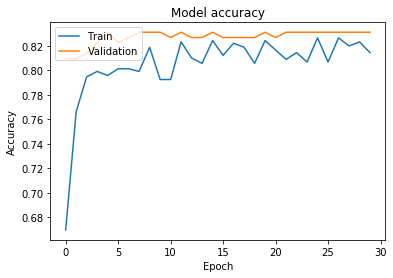

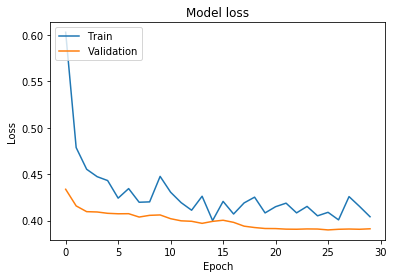

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[112  32]
 [ 18 126]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 18 false negatives and 126 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   
1                             0.84                              0.84   
2                             0.82                              0.83   

   Simple NN Dropout: 0.2 Recall  Simple NN Dropout: 0.2 True Neg.  \
0                           0.83                             


Epoch 00016: val_loss improved from 0.34164 to 0.34065, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 17/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4058 - acc: 0.8186 - val_loss: 0.3402 - val_acc: 0.8398

Epoch 00017: val_loss improved from 0.34065 to 0.34017, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 18/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4020 - acc: 0.8120 - val_loss: 0.3380 - val_acc: 0.8398

Epoch 00018: val_loss improved from 0.34017 to 0.33797, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 19/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3906 - acc: 0.8206 - val_loss: 0.3371 - val_acc: 0.8398

Epoch 00019: val_loss improved from 0.33797 to 0.33706, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 20/50
92/92 [=====================

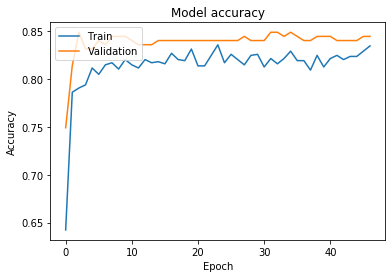

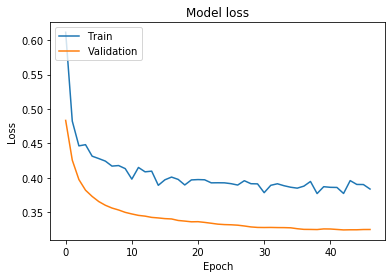

F1 score is:  0.84
Recall score is:  0.85
Precision score is:  0.84
Confusion matrix: 
 [[115  29]
 [ 16 128]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 16 false negatives and 128 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5009 - acc: 0.7696 - val_loss: 0.4054 - val_acc: 0.8182

Epoch 00001: val_loss improved from inf to 0.40539, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4430 - acc: 0.7924 - val_loss: 0.3926 - val_acc: 0.8398

Epoch 00002: val_loss improved from 0.40539 to 0.39262, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4346 - acc: 0.8141 - val_loss: 0.3901


Epoch 00032: val_loss improved from 0.34195 to 0.34192, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 33/50
92/92 [==============================] - 7s 78ms/step - loss: 0.4024 - acc: 0.8164 - val_loss: 0.3420 - val_acc: 0.8485

Epoch 00033: val_loss did not improve from 0.34192
Epoch 34/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3946 - acc: 0.8110 - val_loss: 0.3425 - val_acc: 0.8442

Epoch 00034: val_loss did not improve from 0.34192
Epoch 35/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4142 - acc: 0.8088 - val_loss: 0.3422 - val_acc: 0.8485

Epoch 00035: val_loss did not improve from 0.34192
Epoch 36/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4023 - acc: 0.8186 - val_loss: 0.3425 - val_acc: 0.8485

Epoch 00036: val_loss did not improve from 0.34192
Epoch 00036: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Dropout: 0.3 : Counter: 3, Ac

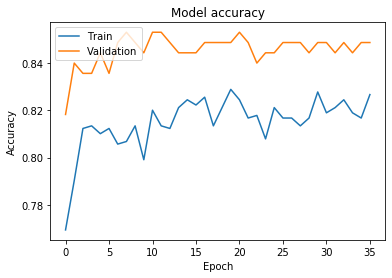

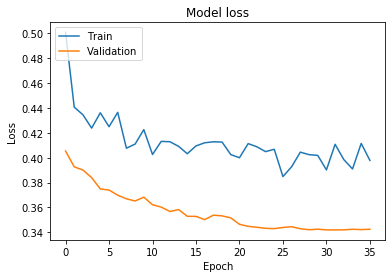

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[111  33]
 [ 16 128]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 16 false negatives and 128 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5926 - acc: 0.6902 - val_loss: 0.4345 - val_acc: 0.7879

Epoch 00001: val_loss improved from inf to 0.43453, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4893 - acc: 0.7675 - val_loss: 0.4006 - val_acc: 0.8139

Epoch 00002: val_loss improved from 0.43453 to 0.40063, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4526 - acc: 0.7979 - val_loss: 0.3909

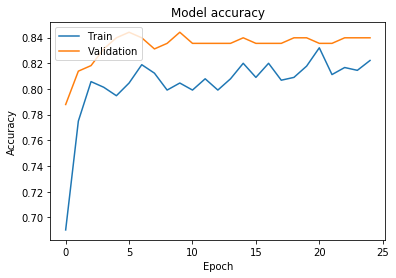

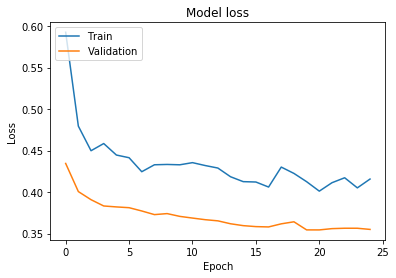

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[107  37]
 [ 15 129]]
From the confusion matrix above there are 107 true negatives and 37 false positives.
There are 15 false negatives and 129 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   
1                             0.84                              0.84   
2                             0.82                              0.83   
3                             0.84                    

92/92 [==============================] - 7s 75ms/step - loss: 0.4209 - acc: 0.8012 - val_loss: 0.3732 - val_acc: 0.8398

Epoch 00014: val_loss improved from 0.37628 to 0.37325, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 15/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4170 - acc: 0.8239 - val_loss: 0.3746 - val_acc: 0.8398

Epoch 00015: val_loss did not improve from 0.37325
Epoch 16/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4182 - acc: 0.8077 - val_loss: 0.3736 - val_acc: 0.8398

Epoch 00016: val_loss did not improve from 0.37325
Epoch 17/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4057 - acc: 0.8099 - val_loss: 0.3717 - val_acc: 0.8398

Epoch 00017: val_loss improved from 0.37325 to 0.37172, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 18/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4182 - acc: 0.8130 - v

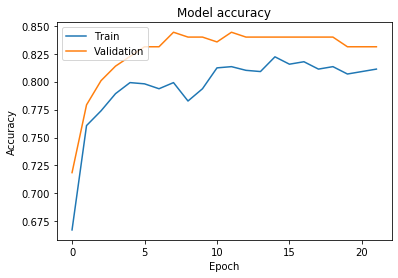

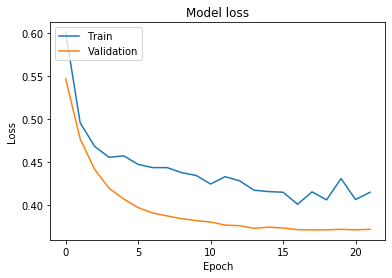

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[113  31]
 [ 18 126]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 18 false negatives and 126 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5546 - acc: 0.7304 - val_loss: 0.4962 - val_acc: 0.7879

Epoch 00001: val_loss improved from inf to 0.49623, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4877 - acc: 0.7751 - val_loss: 0.4561 - val_acc: 0.8009

Epoch 00002: val_loss improved from 0.49623 to 0.45607, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4803 - acc: 0.7794 - val_loss: 0.4297

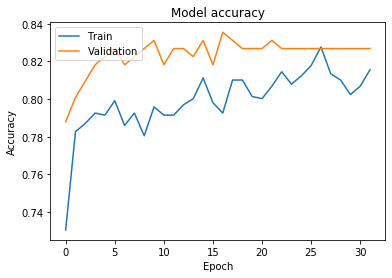

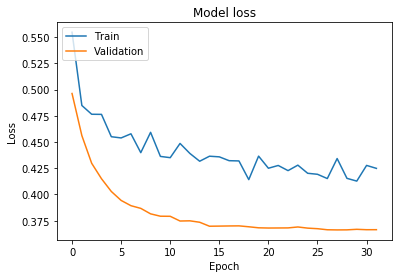

F1 score is:  0.84
Recall score is:  0.85
Precision score is:  0.84
Confusion matrix: 
 [[114  30]
 [ 15 129]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 15 false negatives and 129 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.6075 - acc: 0.6815 - val_loss: 0.4735 - val_acc: 0.8139

Epoch 00001: val_loss improved from inf to 0.47350, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.5143 - acc: 0.7380 - val_loss: 0.4168 - val_acc: 0.8442

Epoch 00002: val_loss improved from 0.47350 to 0.41678, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4864 - acc: 0.7793 - val_loss: 0.4008

92/92 [==============================] - 7s 77ms/step - loss: 0.4166 - acc: 0.8022 - val_loss: 0.3613 - val_acc: 0.8398

Epoch 00033: val_loss improved from 0.36181 to 0.36132, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 34/50
92/92 [==============================] - 7s 80ms/step - loss: 0.4096 - acc: 0.8130 - val_loss: 0.3613 - val_acc: 0.8398

Epoch 00034: val_loss did not improve from 0.36132
Epoch 35/50
92/92 [==============================] - 7s 79ms/step - loss: 0.4191 - acc: 0.8098 - val_loss: 0.3618 - val_acc: 0.8398

Epoch 00035: val_loss did not improve from 0.36132
Epoch 36/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4243 - acc: 0.8185 - val_loss: 0.3620 - val_acc: 0.8398

Epoch 00036: val_loss did not improve from 0.36132
Epoch 37/50
92/92 [==============================] - 7s 79ms/step - loss: 0.4172 - acc: 0.8087 - val_loss: 0.3624 - val_acc: 0.8398

Epoch 00037: val_loss did not improve from 0.36132
Epo

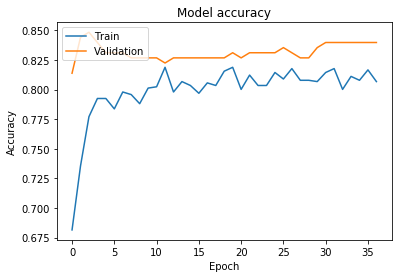

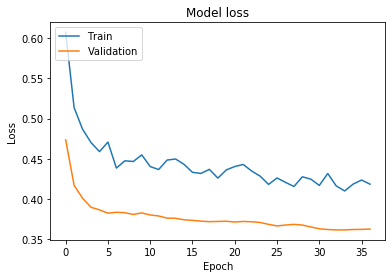

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[113  31]
 [ 19 125]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 19 false negatives and 125 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   
1                             0.84                              0.84   
2                             0.82              


Epoch 00011: val_loss did not improve from 0.37696
Epoch 12/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4130 - acc: 0.8141 - val_loss: 0.3753 - val_acc: 0.8398

Epoch 00012: val_loss improved from 0.37696 to 0.37530, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 13/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4152 - acc: 0.8098 - val_loss: 0.3730 - val_acc: 0.8398

Epoch 00013: val_loss improved from 0.37530 to 0.37301, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 14/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4171 - acc: 0.8119 - val_loss: 0.3704 - val_acc: 0.8485

Epoch 00014: val_loss improved from 0.37301 to 0.37041, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 15/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4104 - acc: 0.8163 - val_loss: 0.3669 - val_acc: 0.84

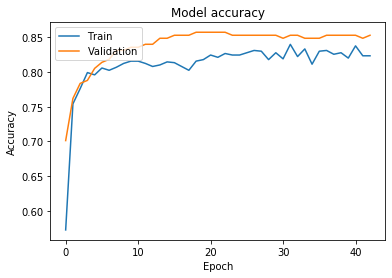

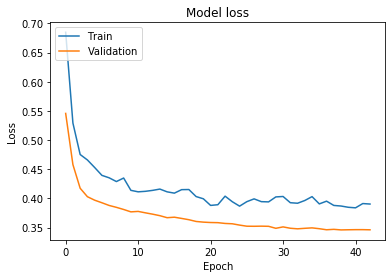

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[107  37]
 [ 14 130]]
From the confusion matrix above there are 107 true negatives and 37 false positives.
There are 14 false negatives and 130 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.5474 - acc: 0.7315 - val_loss: 0.4818 - val_acc: 0.7619

Epoch 00001: val_loss improved from inf to 0.48175, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4740 - acc: 0.7925 - val_loss: 0.4450 - val_acc: 0.7965

Epoch 00002: val_loss improved from 0.48175 to 0.44504, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4573 - acc: 0.7870 - val_loss: 0.4210

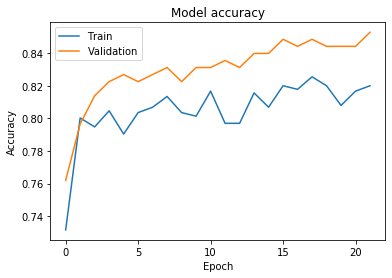

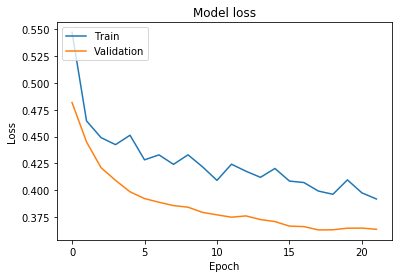

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[114  30]
 [ 17 127]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 17 false negatives and 127 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.7055 - acc: 0.5663 - val_loss: 0.4649 - val_acc: 0.7532

Epoch 00001: val_loss improved from inf to 0.46487, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.5030 - acc: 0.7793 - val_loss: 0.4214 - val_acc: 0.7662

Epoch 00002: val_loss improved from 0.46487 to 0.42139, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4642 - acc: 0.7804 - val_loss: 0.4053

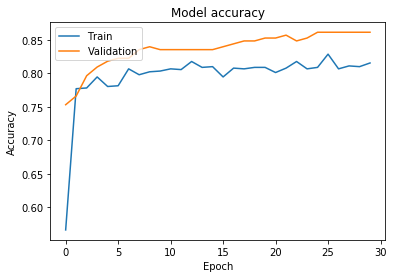

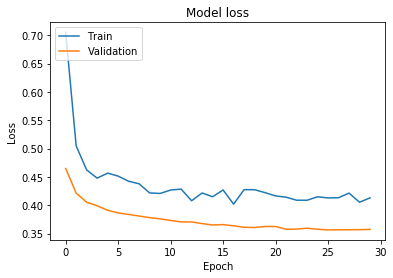

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[116  28]
 [ 20 124]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 20 false negatives and 124 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   
5       5                           85.28                            82.29   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83                              0.83   
1                             0.84        

92/92 [==============================] - 7s 75ms/step - loss: 0.4199 - acc: 0.8043 - val_loss: 0.3472 - val_acc: 0.8182

Epoch 00009: val_loss improved from 0.34871 to 0.34716, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 10/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4220 - acc: 0.8185 - val_loss: 0.3477 - val_acc: 0.8139

Epoch 00010: val_loss did not improve from 0.34716
Epoch 11/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4183 - acc: 0.8044 - val_loss: 0.3452 - val_acc: 0.8225

Epoch 00011: val_loss improved from 0.34716 to 0.34518, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 12/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4226 - acc: 0.8043 - val_loss: 0.3433 - val_acc: 0.8182

Epoch 00012: val_loss improved from 0.34518 to 0.34326, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 13/

92/92 [==============================] - 7s 75ms/step - loss: 0.3992 - acc: 0.8099 - val_loss: 0.3112 - val_acc: 0.8485

Epoch 00042: val_loss improved from 0.31180 to 0.31120, saving model to ./model/Simple NN Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 43/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3946 - acc: 0.8348 - val_loss: 0.3116 - val_acc: 0.8442

Epoch 00043: val_loss did not improve from 0.31120
Epoch 44/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3897 - acc: 0.8186 - val_loss: 0.3139 - val_acc: 0.8485

Epoch 00044: val_loss did not improve from 0.31120
Epoch 45/50
92/92 [==============================] - 7s 77ms/step - loss: 0.3890 - acc: 0.8304 - val_loss: 0.3126 - val_acc: 0.8442

Epoch 00045: val_loss did not improve from 0.31120
Epoch 46/50
92/92 [==============================] - 7s 77ms/step - loss: 0.3896 - acc: 0.8262 - val_loss: 0.3092 - val_acc: 0.8442

Epoch 00046: val_loss improved from 0.31120 to 0.30921

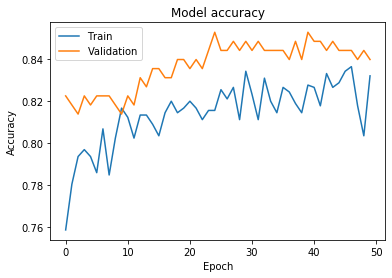

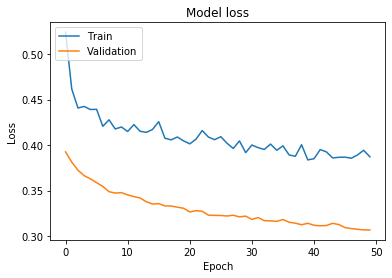

F1 score is:  0.85
Recall score is:  0.85
Precision score is:  0.85
Confusion matrix: 
 [[121  23]
 [ 20 124]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 20 false negatives and 124 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 85ms/step - loss: 0.6161 - acc: 0.6522 - val_loss: 0.4438 - val_acc: 0.7922

Epoch 00001: val_loss improved from inf to 0.44379, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4784 - acc: 0.7674 - val_loss: 0.4019 - val_acc: 0.8182

Epoch 00002: val_loss improved from 0.44379 to 0.40187, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4728 - acc: 0.7751 - val_loss: 0.3836

92/92 [==============================] - 8s 83ms/step - loss: 0.4134 - acc: 0.8120 - val_loss: 0.3243 - val_acc: 0.8485

Epoch 00033: val_loss improved from 0.32487 to 0.32427, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 34/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4168 - acc: 0.8055 - val_loss: 0.3244 - val_acc: 0.8485

Epoch 00034: val_loss did not improve from 0.32427
Epoch 35/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4078 - acc: 0.8217 - val_loss: 0.3234 - val_acc: 0.8528

Epoch 00035: val_loss improved from 0.32427 to 0.32343, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 36/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4147 - acc: 0.8185 - val_loss: 0.3231 - val_acc: 0.8528

Epoch 00036: val_loss improved from 0.32343 to 0.32309, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 37/

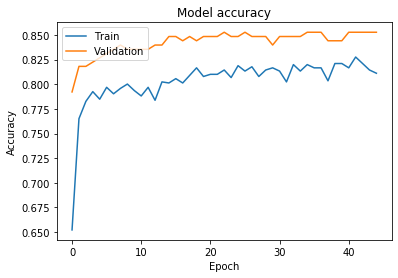

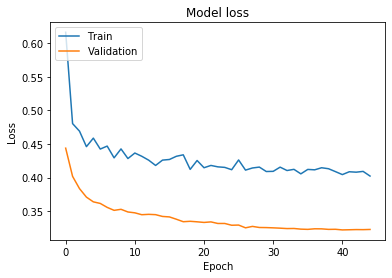

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[117  27]
 [ 19 125]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 19 false negatives and 125 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.6604 - acc: 0.6011 - val_loss: 0.4163 - val_acc: 0.8139

Epoch 00001: val_loss improved from inf to 0.41627, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4988 - acc: 0.7566 - val_loss: 0.3765 - val_acc: 0.8312

Epoch 00002: val_loss improved from 0.41627 to 0.37645, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4841 - acc: 0.7685 - val_loss: 0.3662


Epoch 00031: val_loss improved from 0.31055 to 0.30785, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 32/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4142 - acc: 0.8174 - val_loss: 0.3066 - val_acc: 0.8398

Epoch 00032: val_loss improved from 0.30785 to 0.30662, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 33/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4176 - acc: 0.8228 - val_loss: 0.3052 - val_acc: 0.8398

Epoch 00033: val_loss improved from 0.30662 to 0.30523, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 34/50
92/92 [==============================] - 7s 78ms/step - loss: 0.4091 - acc: 0.8175 - val_loss: 0.3063 - val_acc: 0.8398

Epoch 00034: val_loss did not improve from 0.30523
Epoch 35/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4174 - acc: 0.8077 - val_loss: 0.3079 - val_acc: 0.83

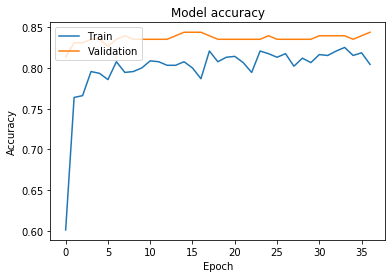

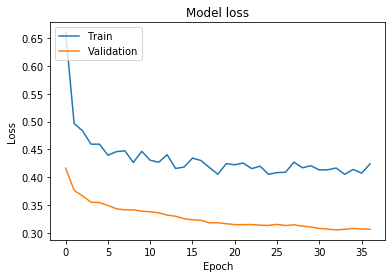

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[116  28]
 [ 19 125]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 19 false negatives and 125 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   
5       5                           85.28                            82.29   
6       6                           84.42                            85.07   

   Simple NN Dropout: 0.2 F1 score  Simple NN Dropout: 0.2 Precision  \
0                             0.83  

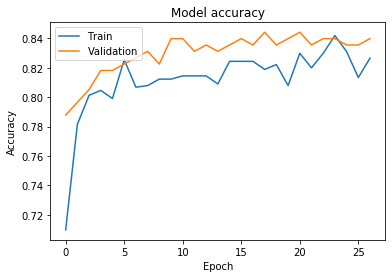

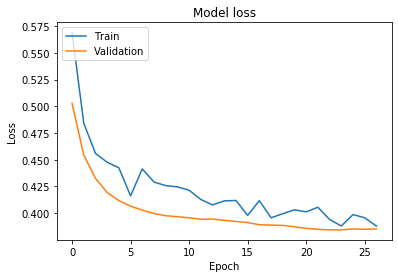

F1 score is:  0.85
Recall score is:  0.85
Precision score is:  0.85
Confusion matrix: 
 [[114  30]
 [ 14 130]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 14 false negatives and 130 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.5739 - acc: 0.6804 - val_loss: 0.4127 - val_acc: 0.7965

Epoch 00001: val_loss improved from inf to 0.41274, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4624 - acc: 0.7925 - val_loss: 0.3947 - val_acc: 0.8225

Epoch 00002: val_loss improved from 0.41274 to 0.39475, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4517 - acc: 0.7892 - val_loss: 0.3913

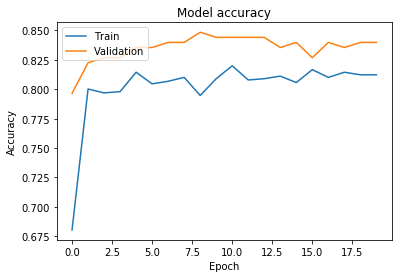

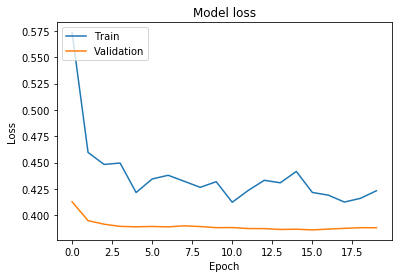

F1 score is:  0.83
Recall score is:  0.84
Precision score is:  0.83
Confusion matrix: 
 [[113  31]
 [ 17 127]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 17 false negatives and 127 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.6068 - acc: 0.6641 - val_loss: 0.4275 - val_acc: 0.8182

Epoch 00001: val_loss improved from inf to 0.42753, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4784 - acc: 0.7967 - val_loss: 0.4156 - val_acc: 0.8398

Epoch 00002: val_loss improved from 0.42753 to 0.41560, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4681 - acc: 0.8022 - val_loss: 0.4093

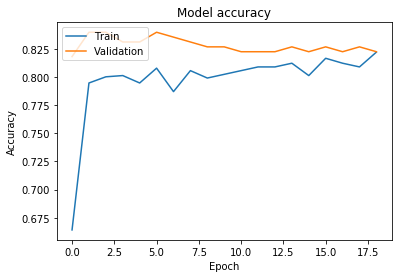

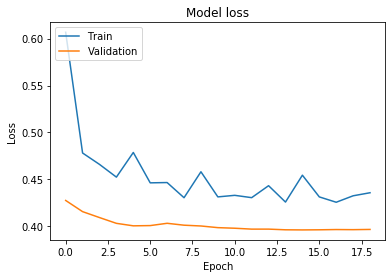

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[113  31]
 [ 15 129]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 15 false negatives and 129 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   
5       5                           85.28                            82.29   
6       6                           84.42                            85.07   
7       7                           83.98                            84.72   

   Simple NN Dropout: 0.2 F1 s

92/92 [==============================] - 7s 75ms/step - loss: 0.4377 - acc: 0.8108 - val_loss: 0.4030 - val_acc: 0.8139

Epoch 00004: val_loss did not improve from 0.40082
Epoch 5/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4589 - acc: 0.7849 - val_loss: 0.4025 - val_acc: 0.8009

Epoch 00005: val_loss did not improve from 0.40082
Epoch 6/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4259 - acc: 0.8130 - val_loss: 0.4012 - val_acc: 0.8052

Epoch 00006: val_loss did not improve from 0.40082
Epoch 7/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4314 - acc: 0.8000 - val_loss: 0.4027 - val_acc: 0.7965

Epoch 00007: val_loss did not improve from 0.40082
Epoch 00007: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Dropout: 0.2 : Counter: 8, Accuracies: Validation: 80.52 %, Test: 82.99 %


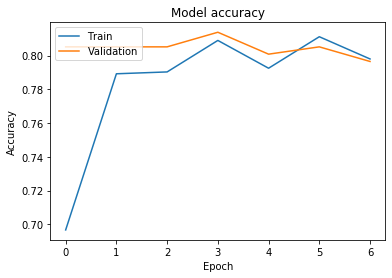

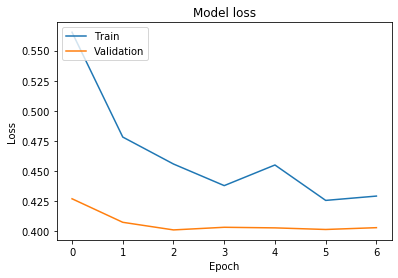

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[111  33]
 [ 16 128]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 16 false negatives and 128 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5919 - acc: 0.6967 - val_loss: 0.4621 - val_acc: 0.7792

Epoch 00001: val_loss improved from inf to 0.46210, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4827 - acc: 0.7598 - val_loss: 0.4245 - val_acc: 0.7879

Epoch 00002: val_loss improved from 0.46210 to 0.42450, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 8s 87ms/step - loss: 0.4617 - acc: 0.7891 - val_loss: 0.4215

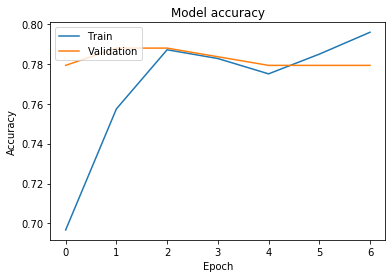

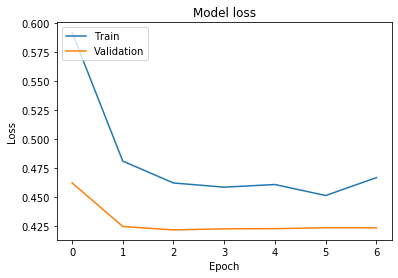

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[111  33]
 [ 22 122]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 22 false negatives and 122 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.6021 - acc: 0.6750 - val_loss: 0.4606 - val_acc: 0.7965

Epoch 00001: val_loss improved from inf to 0.46056, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4880 - acc: 0.7891 - val_loss: 0.4199 - val_acc: 0.7879

Epoch 00002: val_loss improved from 0.46056 to 0.41986, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4636 - acc: 0.7674 - val_loss: 0.4099

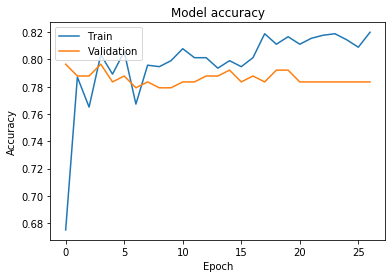

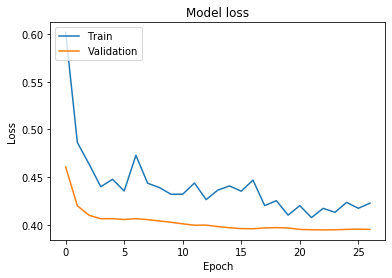

F1 score is:  0.86
Recall score is:  0.86
Precision score is:  0.86
Confusion matrix: 
 [[118  26]
 [ 14 130]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 14 false negatives and 130 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   
5       5                           85.28                            82.29   
6       6                           84.42                            85.07   
7       7                           83.98                            84.72   
8       8                      

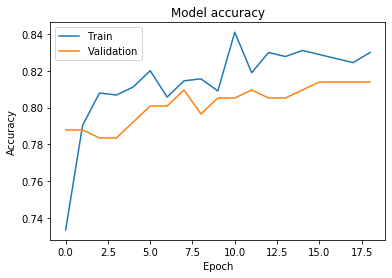

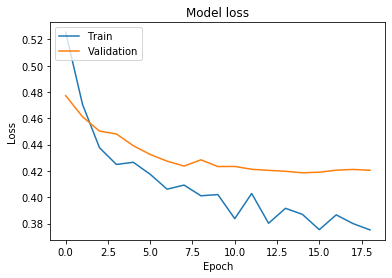

F1 score is:  0.8
Recall score is:  0.82
Precision score is:  0.8
Confusion matrix: 
 [[ 98  46]
 [ 11 133]]
From the confusion matrix above there are 98 true negatives and 46 false positives.
There are 11 false negatives and 133 true positives. 

Simple NN Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5304 - acc: 0.7163 - val_loss: 0.4418 - val_acc: 0.8182

Epoch 00001: val_loss improved from inf to 0.44175, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4448 - acc: 0.7881 - val_loss: 0.4274 - val_acc: 0.8095

Epoch 00002: val_loss improved from 0.44175 to 0.42735, saving model to ./model/Simple NN Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4183 - acc: 0.8152 - val_loss: 0.4263 - 

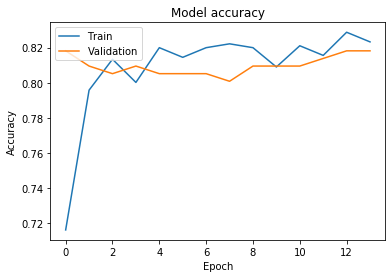

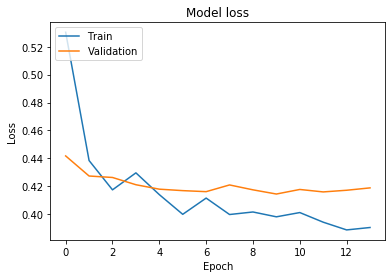

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[113  31]
 [ 18 126]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 18 false negatives and 126 true positives. 

Simple NN Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5418 - acc: 0.7261 - val_loss: 0.4472 - val_acc: 0.8225

Epoch 00001: val_loss improved from inf to 0.44716, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4608 - acc: 0.7740 - val_loss: 0.4316 - val_acc: 0.8052

Epoch 00002: val_loss improved from 0.44716 to 0.43155, saving model to ./model/Simple NN Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4477 - acc: 0.7956 - val_loss: 0.4285

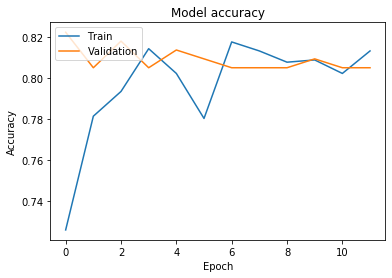

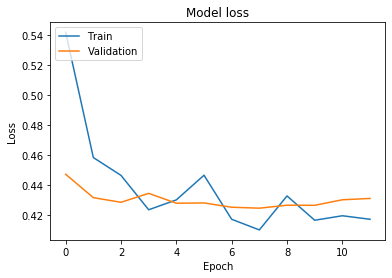

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[117  27]
 [ 20 124]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 20 false negatives and 124 true positives. 

results_data 

   Counter  Simple NN Dropout: 0.2 Val Acc  Simple NN Dropout: 0.2 Test Acc  \
0       0                           85.71                            83.33   
1       1                           83.12                            83.68   
2       2                           83.55                            81.94   
3       3                           83.98                            84.38   
4       4                           83.98                            82.99   
5       5                           85.28                            82.29   
6       6                           84.42                            85.07   
7       7                           83.98                            84.72   
8       8                      

In [13]:
start = time.time()
print(datetime.now())
print('X, y shapes: ', X.shape, y.shape)

#float32 gives faster speed and negligible loss of precision
X = X.astype('float32')

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)

    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    #Image preprocessing
    X_band_train_val = X_train_val[:,:,:,0:3].copy() #Disp, phase and coherence treated as one 3 band image
    X_rgb_train_val = X_train_val[:,:,:,3:6].copy() #RGB Sentinel image 
    print('X_band_train_val processed: max, min', np.max(X_band_train_val), np.min(X_band_train_val))
    print('X_rgb_train_val processed: max, min', np.max(X_rgb_train_val), np.min(X_rgb_train_val))
    X_band_test = X_test[:,:,:,0:3].copy() #Disp, phase and coherence treated as one 3 band image
    X_rgb_test = X_test[:,:,:,3:6].copy() #RGB Sentinel image 
    print('X_band_test processed: max, min', np.max(X_band_test), np.min(X_band_test))
    print('X_rgb_test processed: max, min', np.max(X_rgb_test), np.min(X_rgb_test))
     
    #Image preprocessing 
    image_size = 224
    
    del X_train_val, X_test
    
    results = trainModel(img_res, X_band_train_val, X_band_test, X_rgb_train_val, 
                         X_rgb_test, y_train_val, y_test)
    
#Save results to CSV
results.to_csv('./model/' + 'ConvNet2_Convolutional_Neural_Network_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print('Total running time (s): %i s' % (elapsed))
print('Total running time (min.s): %i min.s' % (elapsed/60.0))
print('Total running time (h): %.2f hours' % (elapsed/3600.0))
print(datetime.now())

## Note
- **The results are contained in the *'ConvNet2_Convolutional_Neural_Network_Results.csv'* file in the *model* folder.**